<a href="https://colab.research.google.com/github/Traceytyh/deep-learning-course/blob/master/4commoncnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from keras import backend as K
import scipy.ndimage as nd
from keras.models import Sequential,load_model
from keras import regularizers
from keras import initializers
from keras import metrics
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Convolution2D, MaxPooling2D, BatchNormalization, ReLU, LeakyReLU, GlobalAveragePooling2D
from keras import layers
from keras import models
from keras.applications.resnet50 import ResNet50
from keras.optimizers import legacy
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import time
import cv2
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Lambda, Input

# download TinyImageNet
! git clone https://github.com/seshuad/IMagenet

def get_id_dictionary():
    id_dict = {}
    for i, line in enumerate(open('IMagenet/tiny-imagenet-200/wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict
def get_class_to_id_dict():
    id_dict = get_id_dictionary()
    all_classes = {}
    result = {}
    for i, line in enumerate(open('IMagenet/tiny-imagenet-200/words.txt', 'r')):
        n_id, word = line.split('\t')[:2]
        all_classes[n_id] = word
    for key, value in id_dict.items():
        result[value] = (key, all_classes[key])
    return result

def get_data(id_dict):

    print('starting loading data')
    train_data, val_data, test_data = [], [], []
    train_labels, val_labels, test_labels = [], [], []
    t = time.time()
    for key, value in id_dict.items():
        train_data += [cv2.imread('IMagenet/tiny-imagenet-200/train/{}/images/{}_{}.JPEG'.format(key, key, str(i))) for i in range(450)]
        train_labels_ = np.array([[0]*200]*450)
        train_labels_[:, value] = 1
        train_labels += train_labels_.tolist()
        val_data += [cv2.imread('IMagenet/tiny-imagenet-200/train/{}/images/{}_{}.JPEG'.format(key, key, str(i))) for i in range(450, 500)]
        val_labels_ = np.array([[0]*200]*50)
        val_labels_[:, value] = 1
        val_labels += val_labels_.tolist()

    for line in open('IMagenet/tiny-imagenet-200/val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        test_data.append(cv2.imread('IMagenet/tiny-imagenet-200/val/images/{}'.format(img_name)))

        test_labels_ = np.array([[0]*200])
        test_labels_[0, id_dict[class_id]] = 1
        test_labels += test_labels_.tolist()

    print('finished loading data, in {} seconds'.format(time.time() - t))

    return np.array(train_data), np.array(train_labels), np.array(val_data), np.array(val_labels), np.array(test_data), np.array(test_labels)
def shuffle_data(train_data, train_labels, val_data, val_labels):
    # This function shuffles separately the train set and the
    # validation set
    size = len(train_data)
    train_idx = np.arange(size)
    np.random.shuffle(train_idx)
    size = len(val_data)
    val_idx = np.arange(size)
    np.random.shuffle(val_idx)

    return train_data[train_idx], train_labels[train_idx], val_data[val_idx], val_labels[val_idx]

train_data, train_labels, val_data, val_labels, test_data, test_labels = get_data(get_id_dictionary())
train_data, train_labels, val_data, val_labels = shuffle_data(train_data, train_labels, val_data, val_labels)

train_data = train_data.astype('float32') / 255.
val_data = val_data.astype('float32') / 255.
test_data = test_data.astype('float32') / 255.

mean = np.mean(train_data,axis=(0,1,2,3))
std = np.std(train_data, axis=(0, 1, 2, 3))
train_data = (train_data-mean)/(std+1e-7)
val_data = (val_data-mean)/(std+1e-7)
test_data = (test_data-mean)/(std+1e-7)

model3 = ResNet50(include_top=False, input_shape=(64,64,3), weights='imagenet')
for layer3 in model3.layers[:]:
    layer3.trainable = False
output3 = model3.output
output3 = GlobalAveragePooling2D()(output3)
output3 = Dense(units=200, activation='softmax')(output3)
model3 = Model(model3.input, output3)

early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=4, restore_best_weights=True)
model3.compile(optimizer=legacy.Adam(lr=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history3 = model3.fit(train_data, train_labels, epochs=20, batch_size=128, validation_data=(val_data, val_labels), callbacks=[early_stopping])

start_time = time.time()
score3 = model3.evaluate(test_data, test_labels)
time_elapsed = time.time() - start_time
print('Test loss:',  score3[0])
print('Test accuracy:',score3[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(test_data)))


Cloning into 'IMagenet'...
remote: Enumerating objects: 120594, done.
remote: Total 120594 (delta 0), reused 0 (delta 0), pack-reused 120594
Receiving objects: 100% (120594/120594), 212.68 MiB | 26.95 MiB/s, done.
Resolving deltas: 100% (1115/1115), done.
Updating files: 100% (120206/120206), done.
starting loading data
finished loading data, in 12.70301866531372 seconds


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
704/704 [==============================] - 36s 43ms/step - loss: 5.1899 - categorical_accuracy: 0.0197 - val_loss: 5.0383 - val_categorical_accuracy: 0.0369
Epoch 2/20
704/704 [==============================] - 28s 39ms/step - loss: 4.9405 - categorical_accuracy: 0.0473 - val_loss: 4.8910 - val_categorical_accuracy: 0.0535
Epoch 3/20
704/704 [==============================] - 28s 40ms/step - loss: 4.8067 - categorical_accuracy: 0.0646 - val_loss: 4.7965 - val_categorical_accuracy: 0.0663
Epoch 4/20
704/704 [==============================] - 29s 41ms/step - loss: 4.7119 - categorical_accuracy: 0.0766 - val_loss: 4.7289 - val_categorical_accuracy: 0.0740
Epoch 5/20
704/704 [==============================] - 29s 41ms/step - loss: 4.6391 - categorical_accuracy: 0.0858 - val_loss: 4.6776 - val_categorical_accuracy: 0.0793
Epoch 6/20
704/704 [==============================] - 29s 41ms/step - loss: 4.5798 - categorical_accuracy: 0.0923 - val_loss: 4.6369 - val_categorical_accuracy:

NameError: name 'start_time' is not defined

In [4]:
start_time = time.time()
score3 = model3.evaluate(test_data, test_labels)
time_elapsed = time.time() - start_time
print('Test loss:',  score3[0])
print('Test accuracy:',score3[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(test_data)))


313/313 [==============================] - 5s 15ms/step - loss: 4.4077 - categorical_accuracy: 0.1053
Test loss: 4.407741546630859
Test accuracy: 0.10530000180006027
Average inference time per image: 0.5770 (ms)


In [7]:
from keras import backend as K
import scipy.ndimage as nd
from keras.models import Sequential,load_model
from keras import regularizers
from keras import initializers
from keras import metrics
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Convolution2D, MaxPooling2D, BatchNormalization, ReLU, LeakyReLU, GlobalAveragePooling2D
from keras import layers
from keras import models
from keras.applications.resnet50 import ResNet50
from keras.optimizers import legacy
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import time
import cv2
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Lambda, Input

model3 = ResNet50(include_top=False, input_shape=(64,64,3), weights='imagenet')
output3 = model3.output
output3 = GlobalAveragePooling2D()(output3)
output3 = Dense(units=200, activation='softmax')(output3)
model3 = Model(model3.input, output3)

early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=4, restore_best_weights=True)
model3.compile(optimizer=legacy.Adam(lr=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history3 = model3.fit(train_data, train_labels, epochs=20, batch_size=128, validation_data=(val_data, val_labels), callbacks=[early_stopping])

start_time = time.time()
score3 = model3.evaluate(test_data, test_labels)
time_elapsed = time.time() - start_time
print('Test loss:',  score3[0])
print('Test accuracy:',score3[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(test_data)))


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
704/704 [==============================] - 101s 132ms/step - loss: 2.9606 - categorical_accuracy: 0.3561 - val_loss: 2.9777 - val_categorical_accuracy: 0.3273
Epoch 2/20
704/704 [==============================] - 91s 129ms/step - loss: 1.3594 - categorical_accuracy: 0.6544 - val_loss: 1.8942 - val_categorical_accuracy: 0.5376
Epoch 3/20
704/704 [==============================] - 91s 129ms/step - loss: 0.6632 - categorical_accuracy: 0.8264 - val_loss: 1.9496 - val_categorical_accuracy: 0.5471
Epoch 4/20
704/704 [==============================] - 90s 128ms/step - loss: 0.2769 - categorical_accuracy: 0.9321 - val_loss: 2.0872 - val_categorical_accuracy: 0.5467
Epoch 5/20
704/704 [==============================] - 90s 128ms/step - loss: 0.1333 - categorical_accuracy: 0.9707 - val_loss: 2.1668 - val_categorical_accuracy: 0.5457
Epoch 6/20
704/704 [==============================] - 90s 128ms/step - loss: 0.1233 - categorical_accuracy: 0.9703 - val_loss: 2.3145 - val_categorical_ac

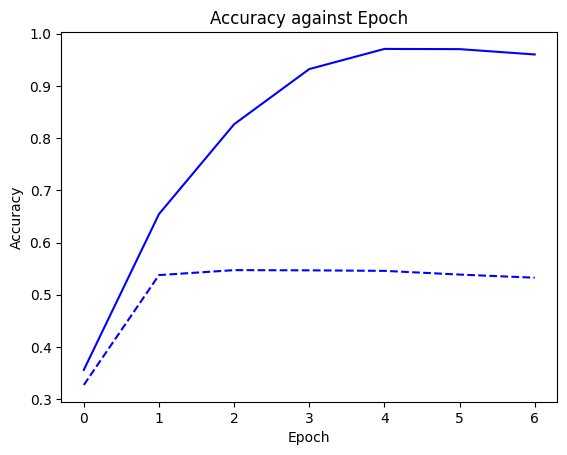

In [8]:

plt.plot(history3.history['categorical_accuracy'], color='blue')
plt.plot(history3.history['val_categorical_accuracy'], linestyle='--', color='blue')

plt.title('Accuracy against Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()


In [4]:
from keras import backend as K
import scipy.ndimage as nd
from keras.models import Sequential,load_model
from keras import regularizers
from keras import initializers
from keras import metrics
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Convolution2D, MaxPooling2D, BatchNormalization, ReLU, LeakyReLU, GlobalAveragePooling2D
from keras import layers
from keras import models
from keras.applications.resnet50 import ResNet50
from keras.optimizers import legacy
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import time
import cv2
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Lambda, Input

# download TinyImageNet
! git clone https://github.com/seshuad/IMagenet

def get_id_dictionary():
    id_dict = {}
    for i, line in enumerate(open('IMagenet/tiny-imagenet-200/wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict
def get_class_to_id_dict():
    id_dict = get_id_dictionary()
    all_classes = {}
    result = {}
    for i, line in enumerate(open('IMagenet/tiny-imagenet-200/words.txt', 'r')):
        n_id, word = line.split('\t')[:2]
        all_classes[n_id] = word
    for key, value in id_dict.items():
        result[value] = (key, all_classes[key])
    return result

def get_data(id_dict):

    print('starting loading data')
    train_data, val_data, test_data = [], [], []
    train_labels, val_labels, test_labels = [], [], []
    t = time.time()
    for key, value in id_dict.items():
        train_data += [cv2.imread('IMagenet/tiny-imagenet-200/train/{}/images/{}_{}.JPEG'.format(key, key, str(i))) for i in range(450)]
        train_labels_ = np.array([[0]*200]*450)
        train_labels_[:, value] = 1
        train_labels += train_labels_.tolist()
        val_data += [cv2.imread('IMagenet/tiny-imagenet-200/train/{}/images/{}_{}.JPEG'.format(key, key, str(i))) for i in range(450, 500)]
        val_labels_ = np.array([[0]*200]*50)
        val_labels_[:, value] = 1
        val_labels += val_labels_.tolist()

    for line in open('IMagenet/tiny-imagenet-200/val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        test_data.append(cv2.imread('IMagenet/tiny-imagenet-200/val/images/{}'.format(img_name)))

        test_labels_ = np.array([[0]*200])
        test_labels_[0, id_dict[class_id]] = 1
        test_labels += test_labels_.tolist()

    print('finished loading data, in {} seconds'.format(time.time() - t))

    return np.array(train_data), np.array(train_labels), np.array(val_data), np.array(val_labels), np.array(test_data), np.array(test_labels)
def shuffle_data(train_data, train_labels, val_data, val_labels):
    # This function shuffles separately the train set and the
    # validation set
    size = len(train_data)
    train_idx = np.arange(size)
    np.random.shuffle(train_idx)
    size = len(val_data)
    val_idx = np.arange(size)
    np.random.shuffle(val_idx)

    return train_data[train_idx], train_labels[train_idx], val_data[val_idx], val_labels[val_idx]

train_data, train_labels, val_data, val_labels, test_data, test_labels = get_data(get_id_dictionary())
train_data, train_labels, val_data, val_labels = shuffle_data(train_data, train_labels, val_data, val_labels)

train_data = train_data.astype('float32') / 255.
val_data = val_data.astype('float32') / 255.
test_data = test_data.astype('float32') / 255.

mean = np.mean(train_data,axis=(0,1,2,3))
std = np.std(train_data, axis=(0, 1, 2, 3))
train_data = (train_data-mean)/(std+1e-7)
val_data = (val_data-mean)/(std+1e-7)
test_data = (test_data-mean)/(std+1e-7)


#Model from scratch
model0 = VGG16(input_shape=(64, 64, 3),include_top=False)
output = model0.output
output = Flatten()(output)
output = Dense(units=4096, activation='relu')(output)
output = Dense(units=4096, activation='relu')(output)
output = Dense(units=200, activation='softmax')(output)
model0 = Model(model0.input, output)


early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=4, restore_best_weights=True)

model0.compile(optimizer=legacy.Adam(lr=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history0 = model0.fit(train_data, train_labels, epochs=20, batch_size=128, validation_data=(val_data, val_labels), callbacks=[early_stopping])

plt.plot(history0.history['acc'], color='blue')
plt.plot(history0.history['val_acc'], linestyle='--', color='blue')

plt.title('Accuracy against Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

start_time = time.time()
score0 = model0.evaluate(test_data, test_labels)
time_elapsed = time.time() - start_time
print('Test loss:', score0[0])
print('Test accuracy:', score0[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(test_data)))

Cloning into 'IMagenet'...
remote: Enumerating objects: 120594, done.
remote: Total 120594 (delta 0), reused 0 (delta 0), pack-reused 120594
Receiving objects: 100% (120594/120594), 212.68 MiB | 37.76 MiB/s, done.
Resolving deltas: 100% (1115/1115), done.
Updating files: 100% (120206/120206), done.
starting loading data
finished loading data, in 12.373809576034546 seconds
Epoch 1/20
704/704 [==============================] - 120s 155ms/step - loss: 2.7852 - categorical_accuracy: 0.3496 - val_loss: 2.1266 - val_categorical_accuracy: 0.4747
Epoch 2/20
704/704 [==============================] - 107s 152ms/step - loss: 1.7593 - categorical_accuracy: 0.5523 - val_loss: 1.9724 - val_categorical_accuracy: 0.5073
Epoch 3/20
704/704 [==============================] - 107s 152ms/step - loss: 1.3267 - categorical_accuracy: 0.6464 - val_loss: 1.8323 - val_categorical_accuracy: 0.5461
Epoch 4/20
704/704 [==============================] - 107s 152ms/step - loss: 0.9675 - categorical_accuracy: 0.7335

KeyError: 'accuracy'

In [11]:
history3 = model3.fit(train_data, train_labels, epochs=20, batch_size=128, validation_data=(val_data, val_labels), callbacks=[early_stopping])


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

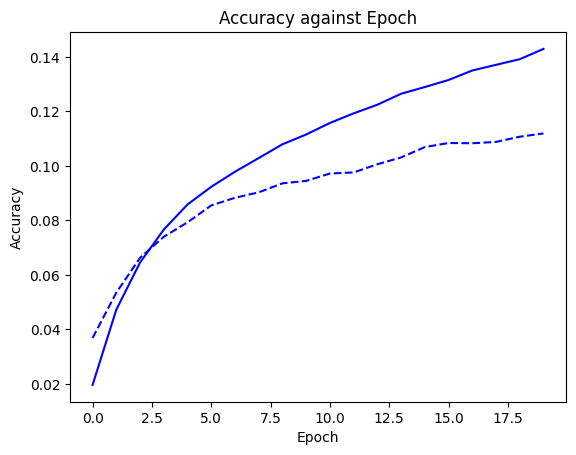

175/313 [===============>..............] - ETA: 2s - loss: 4.4041 - categorical_accuracy: 0.1007

KeyboardInterrupt: 

In [5]:

plt.plot(history3.history['categorical_accuracy'], color='blue')
plt.plot(history3.history['val_categorical_accuracy'], linestyle='--', color='blue')

plt.title('Accuracy against Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

start_time = time.time()
score0 = model3.evaluate(test_data, test_labels)
time_elapsed = time.time() - start_time
print('Test loss:', score0[0])
print('Test accuracy:', score0[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(test_data)))

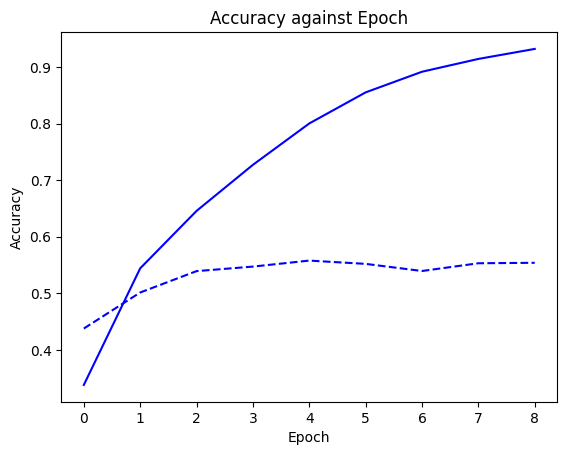

313/313 [==============================] - 5s 15ms/step - loss: 2.0578 - categorical_accuracy: 0.5525
Test loss: 2.0578062534332275
Test accuracy: 0.5525000095367432
Average inference time per image: 0.5787 (ms)


In [10]:

plt.plot(history2.history['categorical_accuracy'], color='blue')
plt.plot(history2.history['val_categorical_accuracy'], linestyle='--', color='blue')

plt.title('Accuracy against Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

start_time = time.time()
score0 = model2.evaluate(test_data, test_labels)
time_elapsed = time.time() - start_time
print('Test loss:', score0[0])
print('Test accuracy:', score0[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(test_data)))

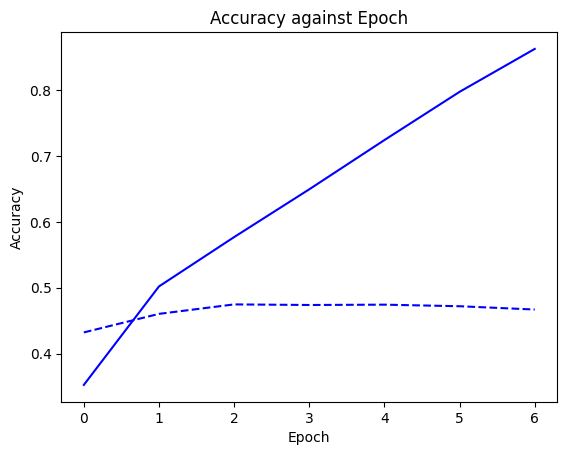

313/313 [==============================] - 5s 15ms/step - loss: 2.2061 - categorical_accuracy: 0.4657
Test loss: 2.206141948699951
Test accuracy: 0.4657000005245209
Average inference time per image: 0.5792 (ms)


In [9]:

plt.plot(history1.history['categorical_accuracy'], color='blue')
plt.plot(history1.history['val_categorical_accuracy'], linestyle='--', color='blue')

plt.title('Accuracy against Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

start_time = time.time()
score0 = model1.evaluate(test_data, test_labels)
time_elapsed = time.time() - start_time
print('Test loss:', score0[0])
print('Test accuracy:', score0[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(test_data)))

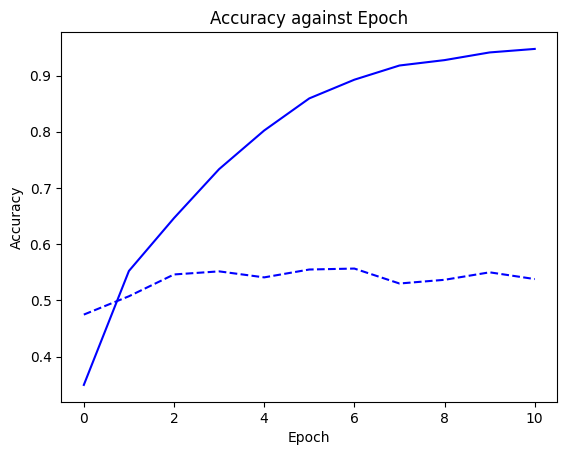

313/313 [==============================] - 6s 15ms/step - loss: 2.3670 - categorical_accuracy: 0.5483
Test loss: 2.3669517040252686
Test accuracy: 0.54830002784729
Average inference time per image: 0.6797 (ms)


In [6]:

plt.plot(history0.history['categorical_accuracy'], color='blue')
plt.plot(history0.history['val_categorical_accuracy'], linestyle='--', color='blue')

plt.title('Accuracy against Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

start_time = time.time()
score0 = model0.evaluate(test_data, test_labels)
time_elapsed = time.time() - start_time
print('Test loss:', score0[0])
print('Test accuracy:', score0[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(test_data)))

In [9]:
from keras.models import load_model

#model1.save('4vgg2.h5')  # creates a HDF5 file 'my_model.h5'
#model2.save('4vgg3.h5')
model3.save('4resnet3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
from keras.applications.resnet50 import ResNet50
model3 = ResNet50(include_top=False, input_shape=(64,64,3), weights='imagenet')
for layer3 in model3.layers[:]:
    layer3.trainable = False
output3 = model3.output
output3 = GlobalAveragePooling2D()(output3)
output3 = Dense(units=200, activation='softmax')(output3)
model3 = Model(model3.input, output3)

early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=4, restore_best_weights=True)
model3.compile(optimizer=legacy.Adam(lr=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history3 = model3.fit(train_data, train_labels, epochs=20, batch_size=128, validation_data=(val_data, val_labels), callbacks=[early_stopping])

score3 = model3.evaluate(test_data, test_labels)
time_elapsed = time.time() - start_time
print('Test loss:',  score3[0])
print('Test accuracy:',score3[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(test_data)))

94765736/94765736 [==============================] - 3s 0us/step


NameError: name 'GlobalAveragePooling2D' is not defined

In [6]:

plt.figure(figsize=(10,4.5))
plt.plot(history0.history['categorical_accuracy'], color='blue')
plt.plot(history0.history['val_categorical_accuracy'], linestyle='--', color='blue')
plt.plot(history1.history['categorical_accuracy'], color='red')
plt.plot(history1.history['val_categorical_accuracy'], linestyle='--', color='red')
plt.plot(history2.history['categorical_accuracy'], color='black')
plt.plot(history2.history['val_categorical_accuracy'], linestyle='--', color='black')

plt.title('Accuracy against Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test', 'Train(Transfer Learning)', 'Test(Transfer Learning)', 'Train(Fine-tune)', 'Test(Fine-tune)'], loc='upper left')
plt.show()


NameError: name 'history0' is not defined

<Figure size 1000x450 with 0 Axes>

In [1]:

#Model from scratch
model0 = VGG16(input_shape=(64, 64, 3),include_top=False)
output = model0.output
output = Flatten()(output)
output = Dense(units=4096, activation='relu')(output)
output = Dense(units=4096, activation='relu')(output)
output = Dense(units=200, activation='softmax')(output)
model0 = Model(model0.input, output)


early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=4, restore_best_weights=True)

model0.compile(optimizer=legacy.Adam(lr=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history0 = model0.fit(train_data, train_labels, epochs=20, batch_size=128, validation_data=(val_data, val_labels), callbacks=[early_stopping])

plt.plot(history0.history['accuracy'], color='blue')
plt.plot(history0.history['val_accuracy'], linestyle='--', color='blue')

plt.title('Accuracy against Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

start_time = time.time()
score0 = model0.evaluate(test_data, test_labels)
time_elapsed = time.time() - start_time
print('Test loss:', score0[0])
print('Test accuracy:', score0[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(test_data)))

58889256/58889256 [==============================] - 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


NameError: name 'train_data' is not defined